In [1]:
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch,torchvision
from torch.nn import *
from tqdm import tqdm
import cv2
from torch.optim import *
# Preproccessing
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    MaxAbsScaler,
    OneHotEncoder,
    Normalizer,
    Binarizer
)
# Decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
# Model Eval
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
# Other
import pickle
import wandb

PROJECT_NAME = 'Samsung-Stock-Price-Prediction'
device = 'cuda:0'
np.random.seed(21)
random.seed(21)
torch.manual_seed(21)

In [2]:
data = pd.read_csv('./data/samsung.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-23,33300.0,33880.0,33140.0,33740.0,29099.779297,11545700.0
1,2016-08-24,33600.0,33640.0,32720.0,33060.0,28513.298828,15938550.0
2,2016-08-25,32600.0,33180.0,32440.0,32780.0,28271.812500,14173800.0
3,2016-08-26,32120.0,32460.0,32060.0,32240.0,27806.070313,12058000.0
4,2016-08-29,32040.0,32800.0,31940.0,32800.0,28289.056641,8925750.0


In [4]:
data = torch.from_numpy(np.array(data['Open'])).view(1,-1)

In [5]:
data_input = data[:1,:-1].float().to(device)
data_target = data[:1,1:].float().to(device)

In [6]:
data_input

tensor([[33300., 33600., 32600.,  ..., 73900., 73500., 73500.]],
       device='cuda:0')

In [7]:
data_target

tensor([[33600., 32600., 32120.,  ..., 73500., 73500., 73300.]],
       device='cuda:0')

In [8]:
class Model(Module):
    def __init__(self,hidden = 128):
        super().__init__()
        self.hidden = hidden
        self.lstm1 = LSTMCell(1,self.hidden).to(device)
        self.lstm2 = LSTMCell(self.hidden,self.hidden).to(device)
        self.linear = Linear(self.hidden,1).to(device)
    def forward(self,X,future=0):
        preds = []
        batch_size = X.shape[0]
        h_t1 = torch.zeros(batch_size,self.hidden,dtype=torch.float32).to(device)
        c_t1 = torch.zeros(batch_size,self.hidden,dtype=torch.float32).to(device)
        h_t2 = torch.zeros(batch_size,self.hidden,dtype=torch.float32).to(device)
        c_t2 = torch.zeros(batch_size,self.hidden,dtype=torch.float32).to(device)
        for X_batch in X.split(1,dim=1):
            X_batch = X_batch.to(device)
            h_t1,c_t1 = self.lstm1(X_batch,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            pred = self.linear(h_t2)
            preds.append(pred)
        for i in range(future):
            h_t1,c_t1 = self.lstm1(X_batch,(h_t1,c_t1))
            h_t1 = h_t1.to(device)
            c_t1 = c_t1.to(device)
            h_t2,c_t2 = self.lstm2(h_t1,(h_t2,c_t2))
            h_t2 = h_t2.to(device)
            c_t2 = c_t2.to(device)
            pred = self.linear(h_t2)
            preds.append(pred)
        preds = torch.cat(preds,dim=1)
        return preds

In [9]:
model = Model()

In [10]:
optimizer = LBFGS(model.parameters(),lr=0.001)

In [11]:
criterion = MSELoss()

In [12]:
epochs = 100

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/100 [00:12<?, ?it/s]


TypeError: Cannot interpret '-1' as a data type

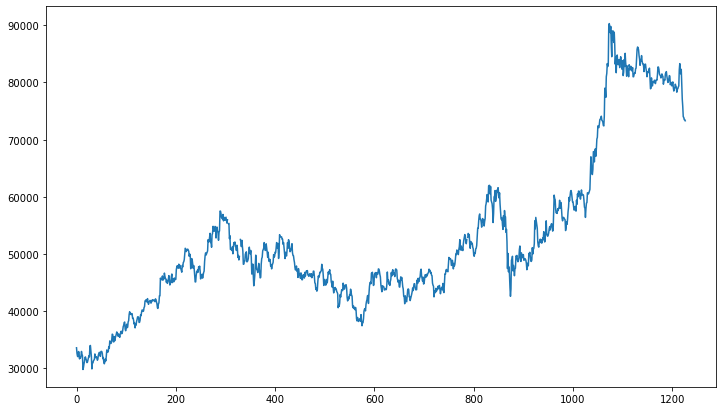

In [13]:
wandb.init(project=PROJECT_NAME,name='baseline')
for epoch in tqdm(range(epochs)):
    def closure():
        optimizer.zero_grad()
        preds = model(data_input)
        preds = preds.to(device)
        loss = criterion(preds,data_target)
        wandb.log({'Loss':loss.item()})
        loss.backward()
        return loss
    optimizer.step(closure)
    with torch.no_grad():
        future = 100
        preds = model(data_input,future)
        loss = criterion(preds[:,:-future],data_target)
        wandb.log({'Val Loss':loss.item()})
        preds = preds.cpu().detach().numpy()
        preds = preds[0]
        plt.figure(figsize=(12,7))
        n = data_input.shape[1]
        plt.plot(np.arange(n),data_target.view(-1).cpu().detach().numpy())
        plt.plot(np.arange(n,n+future),preds[n:])
        plt.savefig('./img.png')
        plt.close()
    wandb.log({'Image':wandb.Image(cv2.imread('./img.png'))})